In [1]:
import contextlib
import io
import glob
import os
import re
from typing import Callable
from urllib.parse import urlparse
import pandas
import requests
import tiktoken
import geopandas as gp
from bs4 import BeautifulSoup
from langchain import BasePromptTemplate, GoogleSearchAPIWrapper, LLMChain
from langchain.base_language import BaseLanguageModel
from langchain.chat_models import ChatOpenAI, AzureChatOpenAI
from pyspark.sql import DataFrame, SparkSession
from tiktoken import Encoding
import pyspark
import pyspark.sql.functions as F

## AI Utils

In [2]:
from typing import Optional, Type

from pyspark.sql import DataFrame


class AIMethodWrapper:
    """
    This class wraps the AI utility functions to allow them to be used directly
    on DataFrame instances. An instance of this class is created each time the
    utility functions are accessed, with the DataFrame and SparkAI instance
    passed to it.
    """

    def __init__(self, spark_ai, df_instance: DataFrame):
        """
        Initialize the AIMethodWrapper with the given SparkAI and DataFrame instance.

        Args:
            spark_ai: The SparkAI instance containing the AI utility methods.
            df_instance: The DataFrame instance on which the utility methods will be used.
        """
        self.spark_ai = spark_ai
        self.df_instance = df_instance

    def transform(self, desc: str, cache: bool = True) -> DataFrame:
        """
        Transform the DataFrame using the given description.

        Args:
            desc: A string description specifying the transformation.
            cache: Indicates whether to utilize a cache for this method.
                If `True`, fetches cached data, if available.
                If `False`, retrieves fresh data and updates cache.

        Returns:
            The transformed DataFrame.
        """
        return self.spark_ai.transform_df(self.df_instance, desc, cache)

    def explain(self, cache: bool = True) -> str:
        """
        Explain the DataFrame.

        Args:
            cache: Indicates whether to utilize a cache for this method.
                If `True`, fetches cached data, if available.
                If `False`, retrieves fresh data and updates cache.

        Returns:
            A string explanation of the DataFrame.

        """
        return self.spark_ai.explain_df(self.df_instance, cache)

    def plot(self, desc: Optional[str] = None, cache: bool = True) -> None:
        """
        Plot the DataFrame.

        Args:
            desc: A string description specifying the plot.
            cache: Indicates whether to utilize a cache for this method.
                If `True`, fetches cached data, if available.
                If `False`, retrieves fresh data and updates cache.
        """
        return self.spark_ai.plot_df(self.df_instance, desc, cache)

    def verify(self, desc: str, cache: bool = True) -> None:
        """
        Verify the DataFrame using the given description.

        Args:
            desc: A string description specifying what to verify in the DataFrame.
            cache: Indicates whether to utilize a cache for this method.
                If `True`, fetches cached data, if available.
                If `False`, retrieves fresh data and updates cache.
        """
        return self.spark_ai.verify_df(self.df_instance, desc, cache)


class AIUtils:
    """
    This class is a descriptor that is used to add AI utility methods to DataFrame instances.
    When the utility methods are accessed, it returns a new AIMethodWrapper instance with the
    DataFrame and SparkAI instance passed to it.
    """

    def __init__(self, spark_ai):
        """
        Initialize the AIUtils descriptor with the given SparkAI.

        Args:
            spark_ai: The SparkAI instance containing the AI utility methods.
        """
        self.spark_ai = spark_ai

    def __get__(self, instance: DataFrame, owner: Type[DataFrame]) -> AIMethodWrapper:
        """
        This method is called when the AI utility methods are accessed on a DataFrame instance.
        It returns a new AIMethodWrapper instance with the DataFrame instance and SparkAI passed to it.

        Args:
            instance: The DataFrame instance on which the utility methods are being accessed.
            owner: The class (DataFrame) to which this descriptor is added.

        Returns:
            A new AIMethodWrapper instance.
        """
        return AIMethodWrapper(self.spark_ai, instance)


## File Cache

In [3]:
import json
import os
from abc import ABC, abstractmethod
from typing import Any, Dict, Optional

from langchain.cache import SQLiteCache
from langchain.schema import Generation


class FileCache(ABC):
    """Base interface for a file-based cache."""

    @abstractmethod
    def lookup(self, key: str) -> Optional[str]:
        """Perform a lookup based on the key."""

    @abstractmethod
    def update(self, key: str, val: str) -> None:
        """Update cache based on the key."""

    @abstractmethod
    def clear(self, **kwargs: Any) -> None:
        """Clear cache. Can take additional keyword arguments."""

    @abstractmethod
    def commit_staging_cache(self, staging_cache: Dict[str, str]) -> None:
        """Commit all items from the staging_cache to the cache."""


class SQLiteCacheWrapper(FileCache):
    """Wrapper class for SQLiteCache that ignores llm_string during lookups and updates."""

    def __init__(self, cache_file_location: str):
        """
        Initializes a new instance of the SQLiteCacheWrapper class.

        Args:
            cache_file_location (str): The SQLite file location
        """
        self._sqlite_cache = SQLiteCache(database_path=cache_file_location)

    def lookup(self, key: str) -> Optional[str]:
        """
        Performs a lookup in the SQLiteCache using the given key.

        Args:
            key (str): The key string for the lookup.

        Returns:
            Optional[RETURN_VAL_TYPE]: The cached value corresponding to the key, if available. Otherwise, None.
        """
        lookup_result = self._sqlite_cache.lookup(prompt=key, llm_string="")
        if lookup_result is not None and len(lookup_result) > 0:
            return lookup_result[0].text
        return None

    def update(self, key: str, val: str) -> None:
        """
        Updates the SQLiteCache with the given key and return value.

        Args:
            key (str): The key string.
            val (RETURN_VAL_TYPE): The return value to be cached.
        """
        stored_value = [Generation(text=val)]
        self._sqlite_cache.update(key, "", stored_value)

    def clear(self, **kwargs: Any) -> None:
        """
        Clears the SQLiteCache.

        Args:
            **kwargs: Additional keyword arguments for the clear method of SQLiteCache.
        """
        self._sqlite_cache.clear(**kwargs)

    def commit_staging_cache(self, staging_cache: Dict[str, str]) -> None:
        """
        Commits all items from the staging_cache to the SQLiteCache.

        Args:
            staging_cache (Dict[str, str]): The staging cache to be committed.
        """
        for key, value in staging_cache.items():
            self.update(key, value)


class JsonCache(FileCache):
    """A simple caching system using a JSON file for storage, subclass of FileCache."""

    def __init__(self, filepath: str):
        """Initialize a new JsonCache instance.

        Args:
            filepath (str): The path to the JSON file to use for the cache.
        """
        self.filepath = filepath
        # If cache file exists, load it into memory.
        self.cache = {}
        if os.path.exists(self.filepath):
            with open(self.filepath, "r") as f:
                for line in f:
                    if line.strip():  # Avoid empty lines
                        line_cache = json.loads(line)
                        self.cache[line_cache["key"]] = line_cache["value"]
        # Create an empty staging cache for storing changes before they are
        # committed.
        self.staging_cache: Dict = {}

    def update(self, key: str, value: str) -> None:
        """Store a value in the cache for a given key.

        Args:
            key (str): The key string.
            value (RETURN_VAL_TYPE): The value to store in the cache.
        """
        # Store the value in the staging cache.
        self.staging_cache[key] = value

    def lookup(self, key: str) -> Optional[str]:
        """Retrieve a value from the cache for a given key.

        Args:
            key (str): The key string.

        Returns:
            Optional[RETURN_VAL_TYPE]: The cached value for the given key, or None if no such value exists.
        """
        return self.cache.get(key)

    def commit_staging_cache(self, staging_cache: Dict[str, str]) -> None:
        """Commit all changes in the staging cache to the cache file.

        This method writes all changes in the staging cache to the end of the cache file and then clears
        the staging cache.

        Args:
            staging_cache (Dict[str, str]): The staging cache to be committed.
        """
        # Append the staging cache to the existing cache
        self.cache.update(staging_cache)
        with open(self.filepath, "a") as f:
            for key, value in staging_cache.items():
                json.dump({"key": key, "value": value}, f)
                f.write("\n")
        # Clear the staging cache
        self.staging_cache = {}

    def clear(self, **kwargs: Any) -> None:
        """Clear the cache.

        This method removes all entries from the cache and deletes the cache file.
        """
        self.cache = {}
        self.staging_cache = {}
        os.remove(self.filepath)


## Cache

In [4]:
from typing import Dict, Optional

JsonCache, SQLiteCacheWrapper, FileCache


class Cache:
    """
    This class provides an interface for a simple in-memory and persistent cache system. It keeps an in-memory staging
    cache, which gets updated through the `update` method and can be persisted through the `commit` method. Cache
    lookup is first performed on the in-memory staging cache, and if not found, it is performed on the persistent
    cache.

    Attributes:
        _staging_updates: A dictionary to keep track of the in-memory staging updates.
        _file_cache: An instance of either JsonCache or SQLiteCacheWrapper that acts as the persistent cache.
    """

    def __init__(
        self, cache_file_location: str = ".pyspark_ai.json", file_format: str = "json"
    ):
        """
        Initializes a new instance of the Cache class.

        Args:
            cache_file_location (str, optional): The path to the cache file for the JsonCache or SQLiteCacheWrapper.
                Defaults to ".pyspark_ai.json".
            file_format (str, optional): The format of the file to use for the cache. Defaults to "json".
        """
        self._staging_updates: Dict[str, str] = {}
        if file_format == "json":
            self._file_cache: FileCache = JsonCache(cache_file_location)
        else:
            self._file_cache = SQLiteCacheWrapper(cache_file_location)

    def lookup(self, key: str) -> Optional[str]:
        """
        Performs a lookup in the cache using the given key.

        Args:
            key (str): The key string for the lookup.

        Returns:
            Optional[str]: The cached text corresponding to the key, if available. Otherwise, None.
        """
        # First look in the staging cache
        staging_result = self._staging_updates.get(key)
        if staging_result is not None:
            return staging_result
        # If not found in staging cache, look in the persistent cache
        return self._file_cache.lookup(key)

    def update(self, key: str, val: str) -> None:
        """
        Updates the staging cache with the given key and value.

        Args:
            key (str): The key string.
            val (str): The value to be cached.
        """
        self._staging_updates[key] = val

    def clear(self) -> None:
        """
        Clears both the in-memory staging cache and the persistent cache.
        """
        self._file_cache.clear()
        self._staging_updates = {}

    def commit(self) -> None:
        """
        Commits all the staged updates to the persistent cache.
        """
        self._file_cache.commit_staging_cache(self._staging_updates)
        self._staging_updates = {}


## Code Logger

In [5]:
import logging
import re
import sys

from pygments import highlight
from pygments.formatters import TerminalFormatter
from pygments.lexers import PythonLexer, SqlLexer

GREEN = "\033[92m"  # terminal code for green
RESET = "\033[0m"  # reset terminal color


# Custom Formatter
class CustomFormatter(logging.Formatter):
    def format(self, record):
        return GREEN + "INFO: " + RESET + super().format(record)


class CodeLogger:
    def __init__(self, name):
        self.logger = logging.getLogger(name)
        self.logger.setLevel(logging.INFO)
        if not self.logger.handlers:
            handler = logging.StreamHandler(sys.stdout)
            handler.setFormatter(
                CustomFormatter("%(message)s")
            )  # output only the message
            self.logger.addHandler(handler)

    @staticmethod
    def colorize_code(code, language):
        if not language or language.lower() == "python":
            lexer = PythonLexer()
        elif language.lower() == "sql":
            lexer = SqlLexer()
        else:
            raise ValueError(f"Unsupported language: {language}")
        return highlight(code, lexer, TerminalFormatter())

    def log(self, message):
        # Define pattern to match code blocks with optional language specifiers
        pattern = r"```(python|sql)?(.*?)```"
        # Split message into parts. Every 3rd part will be a code block.
        parts = re.split(pattern, message, flags=re.DOTALL)

        colored_message = ""
        for i in range(0, len(parts), 3):
            # Add regular text to the message
            colored_message += parts[i]
            # If there is a code block, colorize it and add it to the message
            if i + 2 < len(parts):
                colored_message += (
                    "\n```\n" + self.colorize_code(parts[i + 2], parts[i + 1]) + "```"
                )
        # Log the message with colored code blocks
        self.logger.info(colored_message)


## Temp View Utils

In [6]:
import re
import uuid

prefix = "spark_ai_temp_view"
pattern = f"{prefix}_[0-9a-zA-Z]{{6}}"


def random_view_name() -> str:
    """
    Generate a random temp view name.
    """
    return f"{prefix}_{uuid.uuid4().hex[:6]}"


def canonize_string(s: str) -> str:
    """
    Replace all occurrences of 'spark_ai_temp_view' followed by 6 alphanumeric characters with 'spark_ai_temp_view'
     in a given string.

    Args:
        s (str): The string in which to replace substrings.

    Returns:
        str: The modified string with all matching substrings replaced.
    """
    return re.sub(pattern, prefix, s)


def replace_view_name(s: str, random_view: str) -> str:
    """
    Replace all the 'spark_ai_temp_view' followed by 6 alphanumeric characters in a given string with a random view
     name.
    """
    return re.sub(pattern, random_view, s)


## LLM Chain with Cache

In [7]:
from typing import Any, List, Optional

from langchain import LLMChain
from langchain.callbacks.manager import Callbacks

Cache
canonize_string

SKIP_CACHE_TAGS = ["SKIP_CACHE"]


class LLMChainWithCache(LLMChain):
    cache: Cache

    @staticmethod
    def _sort_and_stringify(*args: Any) -> str:
        # Convert all arguments to strings, then sort them
        sorted_args = sorted(str(arg) for arg in args)
        # Join all the sorted, stringified arguments with a space
        result = " ".join(sorted_args)
        return result

    def run(
        self,
        *args: Any,
        callbacks: Callbacks = None,
        tags: Optional[List[str]] = None,
        **kwargs: Any,
    ) -> str:
        assert not args, "The chain expected no arguments"
        prompt_str = canonize_string(self.prompt.format_prompt(**kwargs).to_string())
        use_cache = tags != SKIP_CACHE_TAGS
        cached_result = self.cache.lookup(prompt_str) if use_cache else None
        if cached_result is not None:
            return cached_result
        result = super().run(*args, callbacks=callbacks, tags=tags, **kwargs)
        if use_cache:
            self.cache.update(prompt_str, result)
        return result


## Search Tool with Cache

In [8]:
from typing import Callable

Cache


class SearchToolWithCache:
    def __init__(self, web_search_tool: Callable[[str], str], cache: Cache):
        self.web_search_tool = web_search_tool
        self.cache = cache

    def search(self, query: str) -> str:
        # Try to get the result from the cache
        key = f"web_search:{query}"
        cached_result = self.cache.lookup(key)
        if cached_result is not None:
            return cached_result

        # If the result was not in the cache, use the web_search_tool
        result = self.web_search_tool(query)

        # Update the cache with the new result
        self.cache.update(key, result)

        return result


## Prompt

In [9]:
# flake8: noqa
from langchain import FewShotPromptTemplate
from langchain.prompts.prompt import PromptTemplate

SEARCH_TEMPLATE = """Given a Query and a list of Google Search Results, return the link
from a reputable website which contains the data set to answer the question. {columns}
Query:{query}
Google Search Results:
```
{search_results}
```
The answer MUST contain the url link only
"""

SEARCH_PROMPT = PromptTemplate(
    input_variables=["query", "search_results", "columns"], template=SEARCH_TEMPLATE
)

SQL_TEMPLATE = """Given the following question:
```
{query}
```
I got the following answer from a web page:
```
{web_content}
```
Now help me write a SQL query to store the answer into a temp view.
Give each column a clearly descriptive name (no abbreviations).
If a column can be either String or Numeric, ingest it as Numeric.
Here is an example of how to store data into the temp view {view_name}:
```
CREATE OR REPLACE TEMP VIEW {view_name} AS SELECT * FROM VALUES('Citizen Kane', 1941), ('Schindler\'s List', 1993) AS v1(title, year)
```
{columns}
The answer MUST contain query only and the temp view MUST be {view_name}.
"""

SQL_PROMPT = PromptTemplate(
    input_variables=["query", "web_content", "view_name", "columns"],
    template=SQL_TEMPLATE,
)

TRANSFORM_TEMPLATE = """
Given a Spark temp view `{view_name}` with the following columns:
```
{columns}
```
Write a Spark SQL query to retrieve: {desc}
The answer MUST contain query only. Ensure your answer is correct.
"""

TRANSFORM_PROMPT = PromptTemplate(
    input_variables=["view_name", "columns", "desc"], template=TRANSFORM_TEMPLATE
)

EXPLAIN_PREFIX = """You are an Apache Spark SQL expert, who can summary what a dataframe retrieves. Given an analyzed
query plan of a dataframe, you will
1. convert the dataframe to SQL query. Note that an explain output contains plan
nodes separated by `\\n`. Each plan node has its own expressions and expression ids.
2. summary what the sql query retrieves.
"""

EXPLAIN_SUFFIX = "analyzed_plan: {input}\nexplain:"

_plan1 = """
GlobalLimit 100
    +- LocalLimit 100
       +- Sort [d_year ASC NULLS FIRST, sum_agg DESC NULLS LAST, brand_id ASC NULLS FIRST], true
          +- Aggregate [d_year, i_brand, i_brand_id], [d_year, i_brand_id AS brand_id, i_brand AS brand, sum(ss_ext_sales_price) AS sum_agg]
             +- Filter (((d_date_sk = ss_sold_date_sk) AND (ss_item_sk = i_item_sk)) AND ((i_manufact_id = 128) AND (d_moy = 11)))
                +- Join Inner
                   :- Join Inner
                   :  :- SubqueryAlias dt
                   :  :  +- SubqueryAlias spark_catalog.tpcds_sf1_delta.date_dim
                   :  :     +- Relation spark_catalog.tpcds_sf1_delta.date_dim[d_date_sk,d_date_id,d_date,d_month_seq,d_week_seq,d_quarter_seq,d_year,d_dow,d_moy,d_dom,d_qoy,d_fy_year,d_fy_quarter_seq,d_fy_week_seq,d_day_name,d_quarter_name,d_holiday,d_weekend,d_following_holiday,d_first_dom,d_last_dom,d_same_day_ly,d_same_day_lq,d_current_day,... 4 more fields] parquet
                   :  +- SubqueryAlias spark_catalog.tpcds_sf1_delta.store_sales
                   :     +- Relation spark_catalog.tpcds_sf1_delta.store_sales[ss_sold_date_sk,ss_sold_time_sk,ss_item_sk,ss_customer_sk,ss_cdemo_sk,ss_hdemo_sk,ss_addr_sk,ss_store_sk,ss_promo_sk,ss_ticket_numberL,ss_quantity,ss_wholesale_cost,ss_list_price,ss_sales_price,ss_ext_discount_amt,ss_ext_sales_price,ss_ext_wholesale_cost,ss_ext_list_price,ss_ext_tax,ss_coupon_amt,ss_net_paid,ss_net_paid_inc_tax,ss_net_profit] parquet
                   +- SubqueryAlias spark_catalog.tpcds_sf1_delta.item
                      +- Relation spark_catalog.tpcds_sf1_delta.item[i_item_sk,i_item_id,i_rec_start_date,i_rec_end_date,i_item_desc,i_current_price,i_wholesale_cost,i_brand_id,i_brand,i_class_id,i_class,i_category_id,i_category,i_manufact_id,i_manufact,i_size,i_formulation,i_color,i_units,i_container,i_manager_id,i_product_name] parquet
"""

_explain1 = """
The analyzed plan can be translated into the following SQL query:
```sql
SELECT
  dt.d_year,
  item.i_brand_id brand_id,
  item.i_brand brand,
  SUM(ss_ext_sales_price) sum_agg
FROM date_dim dt, store_sales, item
WHERE dt.d_date_sk = store_sales.ss_sold_date_sk
  AND store_sales.ss_item_sk = item.i_item_sk
  AND item.i_manufact_id = 128
  AND dt.d_moy = 11
GROUP BY dt.d_year, item.i_brand, item.i_brand_id
ORDER BY dt.d_year, sum_agg DESC, brand_id
LIMIT 100
```
In summary, this dataframe is retrieving the top 100 brands (specifically of items manufactured by manufacturer with id 128) with the highest total sales price for each year in the month of November. It presents the results sorted by year, total sales (in descending order), and brand id.
"""

_explain_examples = [{"analyzed_plan": _plan1, "explain": _explain1}]

_example_formatter = """
analyzed_plan: {analyzed_plan}
explain: {explain}
"""

_example_prompt = PromptTemplate(
    input_variables=["analyzed_plan", "explain"], template=_example_formatter
)

EXPLAIN_DF_PROMPT = FewShotPromptTemplate(
    examples=_explain_examples,
    example_prompt=_example_prompt,
    prefix=EXPLAIN_PREFIX,
    suffix=EXPLAIN_SUFFIX,
    input_variables=["input"],
    example_separator="\n\n",
)

PLOT_PROMPT_TEMPLATE = """
You are an Apache Spark SQL expert programmer.
It is forbidden to include old deprecated APIs in your code.
For example, you will not use the pandas method "append" because it is deprecated.

Given a pyspark DataFrame `df`, with the output columns:
{columns}

And an explanation of `df`: {explain}

Write Python code to visualize the result of `df` using plotly. Make sure to use the exact column names of `df`.
Your code may NOT contain "append" anywhere. Instead of append, use pd.concat.
There is no need to install any package with pip. Do include any necessary import statements.
Display the plot directly, instead of saving into an HTML.
Do not use scatter plot to display any kind of percentage data.
You must import and start your Spark session if you use a Spark DataFrame.
Remember to ensure that your code does NOT include "append" anywhere, under any circumstance (use pd.concat instead).
There is no need to read from a csv file. You can use directly the DataFrame `df` as input.
Ensure that your code is correct.
{instruction}
"""

PLOT_PROMPT = PromptTemplate(
    input_variables=["columns", "explain", "instruction"], template=PLOT_PROMPT_TEMPLATE
)

GEOBINS_PLOT_PROMPT_TEMPLATE = """
You are an Apache Spark SQL expert programmer with knowledge in spatial operations.
It is forbidden to include old deprecated APIs in your code.

Given a pyspark DataFrame `df`,with the output columns:
{columns}

And an explanation of `df`: {explain}

Write Python code to perform spatial binning.
Run help on the following custom library geofunctions S to understand how to use it.
There is no need to install any package with pip. Do include any necessary import statements.
{instruction}

Extract the following variables from the instructions and use them in your sample code below:
1. <lon column> (the name of the longitude column)
2. <lat column> (the name of the latitude column)
3. <cell size> (the size of the spatial bin cell)
4. <max count> (the maximum count of the spatial bin cell)


sample code:

import geofunctions as S
import pyspark.sql.functions as F
import geopandas as gp

#Perform Spatial Binning
df = (
    df.select(S.st_lontoq("<lon column>", cell), S.st_lattor("<lat column>", <cell size>))
    .groupBy("q", "r")
    .count()
    .select(
        S.st_qtox("q", <cell size>),
        S.st_rtoy("r", <cell size>),
        "count",
    )
    .select(
        S.st_cell("x", "y", <cell size>).alias("geometry"),
        F.least("count", F.lit(<max count>)).alias("count"),
    )
    .orderBy("count")
)

# this part should be used only when users ask for showing the result in a map
df = df.toPandas()
df.geometry = df.geometry.apply(lambda _: bytes(_))
df.geometry = gp.GeoSeries.from_wkb(df.geometry)
gdf = gp.GeoDataFrame(df, crs="EPSG:3857")
gdf.explore()
"""

GEOBINS_PLOT_PROMPT = PromptTemplate(
    input_variables=["columns", "explain", "instruction"], template=GEOBINS_PLOT_PROMPT_TEMPLATE
)

CREATE_GEOBINS_PROMPT_TEMPLATE = """
You are an Apache Spark SQL expert programmer with knowledge in spatial operations.
It is forbidden to include old deprecated APIs in your code.

Given a pyspark DataFrame `df`,with the output columns:
{columns}

And an explanation of `df`: {explain}

Write Python code to perform spatial binning and output a GeoJSON document to a local disk.
Run help on the following custom library geofunctions S to understand how to use it.
There is no need to install any package with pip. Do include any necessary import statements.
{instruction}

Extract the following variables from the instructions and use them in your sample code below:
1. <lon column> (the name of the longitude column)
2. <lat column> (the name of the latitude column)
3. <cell size> (the size of the spatial bin cell)
4. <max count> (the maximum count of the spatial bin cell)


sample code:

import geofunctions as S
import pyspark.sql.functions as F
import geopandas as gp

#Perform Spatial Binning
df = (
    df.select(S.st_lontoq("<lon column>", cell), S.st_lattor("<lat column>", <cell size>))
    .groupBy("q", "r")
    .count()
    .select(
        S.st_qtox("q", <cell size>),
        S.st_rtoy("r", <cell size>),
        "count",
    )
    .select(
        S.st_cell("x", "y", <cell size>).alias("geometry"),
        F.least("count", F.lit(<max count>)).alias("count"),
    )
    .orderBy("count")
)

# create geodataframe to get Geo_JSON document
df = df.toPandas()
df.geometry = df.geometry.apply(lambda _: bytes(_))
df.geometry = gp.GeoSeries.from_wkb(df.geometry)
gdf = gp.GeoDataFrame(df, crs="EPSG:3857")
geo_json = gdf.to_json()
with open('../output/geobins_json.txt', 'w') as f:
    f.write(geo_json)
"""

CREATE_GEOBINS_PROMPT = PromptTemplate(
    input_variables=["columns", "explain", "instruction"], template=CREATE_GEOBINS_PROMPT_TEMPLATE
)

VERIFY_TEMPLATE = """
Given 1) a PySpark dataframe, df, and 2) a description of expected properties, desc,
generate a Python function to test whether the given dataframe satisfies the expected properties.
Your generated function should take 1 parameter, df, and the return type should be a boolean.
You will call the function, passing in df as the parameter, and return the output (True/False).

In total, your output must follow the format below, exactly (no explanation words):
1. function definition f, in Python (Do NOT surround the function definition with quotes)
2. 1 blank new line
3. Call f on df and assign the result to a variable, result: result = name_of_f(df)
The answer MUST contain python code only. For example, do NOT include "Here is your output:"

Include any necessary import statements INSIDE the function definition, like this:
def gen_random():
    import random
    return random.randint(0, 10)

Your output must follow the format of the example below, exactly:
Input:
df = DataFrame[name: string, age: int]
desc = "expect 5 columns"

Output:
def has_5_columns(df) -> bool:
    # Get the number of columns in the DataFrame
    num_columns = len(df.columns)

    # Check if the number of columns is equal to 5
    if num_columns == 5:
        return True
    else:
        return False

result = has_5_columns(df)

No explanation words (e.g. do not say anything like "Here is your output:")

Here is your input df: {df}
Here is your input description: {desc}
"""

VERIFY_PROMPT = PromptTemplate(input_variables=["df", "desc"], template=VERIFY_TEMPLATE)

UDF_PREFIX = """
This is the documentation for a PySpark user-defined function (udf): pyspark.sql.functions.udf

A udf creates a deterministic, reusable function in Spark. It can take any data type as a parameter,
and by default returns a String (although it can return any data type).
The point is to reuse a function on several dataframes and SQL functions.

Given 1) input arguments, 2) a description of the udf functionality,
3) the udf return type, and 4) the udf function name,
generate and return a callable udf.

Return ONLY the callable resulting udf function (no explanation words).
Include any necessary import statements INSIDE the function definition.
For example:
def gen_random():
    import random
    return random.randint(0, 10)
"""

UDF_SUFFIX = """
input_args_types: {input_args_types}
input_desc: {desc}
return_type: {return_type}
udf_name: {udf_name}
output:\n
"""

_udf_output1 = """
def to_upper(s) -> str:
    if s is not None:
        return s.upper()
"""

_udf_output2 = """
def add_one(x) -> int:
    if x is not None:
        return x + 1
"""

_udf_examples = [
    {
        "input_args_types": "(s: str)",
        "desc": "Convert string s to uppercase",
        "return_type": "str",
        "udf_name": "to_upper",
        "output": _udf_output1,
    },
    {
        "input_args_types": "(x: int)",
        "desc": "Add 1",
        "return_type": "int",
        "udf_name": "add_one",
        "output": _udf_output2,
    },
]

_udf_formatter = """
input_args_types: {input_args_types}
desc: {desc}
return_type: {return_type}
udf_name: {udf_name}
output: {output}
"""

_udf_prompt = PromptTemplate(
    input_variables=["input_args_types", "desc", "return_type", "udf_name", "output"],
    template=_udf_formatter,
)

UDF_PROMPT = FewShotPromptTemplate(
    examples=_udf_examples,
    example_prompt=_udf_prompt,
    prefix=UDF_PREFIX,
    suffix=UDF_SUFFIX,
    input_variables=["input_args_types", "desc", "return_type", "udf_name"],
    example_separator="\n\n",
)


## GeoLLM - Pyspark AI

In [10]:
import contextlib
import io
import os
import re
from typing import Callable, List, Optional
from urllib.parse import urlparse

import pandas as pd  # noqa: F401
import requests
import tiktoken
from bs4 import BeautifulSoup

AIUtils
Cache
CodeLogger
SKIP_CACHE_TAGS, LLMChainWithCache
(
    EXPLAIN_DF_PROMPT,
    PLOT_PROMPT,
    SEARCH_PROMPT,
    SQL_PROMPT,
    TRANSFORM_PROMPT,
    UDF_PROMPT,
    VERIFY_PROMPT,
)
SearchToolWithCache
random_view_name, replace_view_name


class GeoLLM:
    _HTTP_HEADER = {
        "User-Agent": "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36"
        " (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36",
        "Accept": "text/html,application/xhtml+xml,application/xml;q=0.9,*/*;q=0.8",
        "Accept-Language": "en-US,en;q=0.5",
    }

    def __init__(
        self,
        llm: Optional[BaseLanguageModel] = None,
        web_search_tool: Optional[Callable[[str], str]] = None,
        spark_session: Optional[SparkSession] = None,
        enable_cache: bool = True,
        cache_file_format: str = "json",
        cache_file_location: Optional[str] = None,
        encoding: Optional[Encoding] = None,
        max_tokens_of_web_content: int = 3000,
        verbose: bool = True,
    ) -> None:
        """
        Initialize the SparkAI object with the provided parameters.

        :param llm: LLM instance for selecting web search result
                                 and writing the ingestion SQL query.
        :param web_search_tool: optional function to perform web search,
                                Google search will be used if not provided
        :param spark_session: optional SparkSession, a new one will be created if not provided
        :param encoding: optional Encoding, cl100k_base will be used if not provided
        :param max_tokens_of_web_content: maximum tokens of web content after encoding
        """
        self._spark = spark_session or SparkSession.builder.getOrCreate()
        if llm is None:
            llm = ChatOpenAI(model_name="gpt-4", temperature=0)
        self._llm = llm
        self._web_search_tool = web_search_tool or self._default_web_search_tool
        if enable_cache:
            self._enable_cache = enable_cache
            if cache_file_location is not None:
                # if there is parameter setting for it, use the parameter
                self._cache_file_location = cache_file_location
            elif "AI_CACHE_FILE_LOCATION" in os.environ:
                # otherwise read from env variable AI_CACHE_FILE_LOCATION
                self._cache_file_location = os.environ["AI_CACHE_FILE_LOCATION"]
            else:
                # use default value "spark_ai_cache.json"
                self._cache_file_location = "spark_ai_cache.json"
            self._cache = Cache(
                cache_file_location=self._cache_file_location,
                file_format=cache_file_format,
            )
            self._web_search_tool = SearchToolWithCache(
                self._web_search_tool, self._cache
            ).search
        else:
            self._cache = None
            self._enable_cache = False
        self._encoding = encoding or tiktoken.get_encoding("cl100k_base")
        self._max_tokens_of_web_content = max_tokens_of_web_content
        self._search_llm_chain = self._create_llm_chain(prompt=SEARCH_PROMPT)
        self._sql_llm_chain = self._create_llm_chain(prompt=SQL_PROMPT)
        self._explain_chain = self._create_llm_chain(prompt=EXPLAIN_DF_PROMPT)
        self._transform_chain = self._create_llm_chain(prompt=TRANSFORM_PROMPT)
        self._plot_chain = self._create_llm_chain(prompt=PLOT_PROMPT)
        self._geobins_plot_chain = self._create_llm_chain(prompt=GEOBINS_PLOT_PROMPT)
        self._create_geobins_chain = self._create_llm_chain(prompt=CREATE_GEOBINS_PROMPT)
        self._verify_chain = self._create_llm_chain(prompt=VERIFY_PROMPT)
        self._udf_chain = self._create_llm_chain(prompt=UDF_PROMPT)
        self._verbose = verbose
        if verbose:
            self._logger = CodeLogger("spark_ai")

    def _create_llm_chain(self, prompt: BasePromptTemplate):
        if self._cache is None:
            return LLMChain(llm=self._llm, prompt=prompt)

        return LLMChainWithCache(llm=self._llm, prompt=prompt, cache=self._cache)

    @staticmethod
    def _extract_view_name(query: str) -> str:
        """
        Extract the view name from the provided SQL query.

        :param query: SQL query as a string
        :return: view name as a string
        """
        pattern = r"^CREATE(?: OR REPLACE)? TEMP VIEW (\S+)"
        match = re.search(pattern, query, re.IGNORECASE)
        if not match:
            raise ValueError(
                f"The provided query: '{query}' is not valid for creating a temporary view. "
                "Expected pattern: 'CREATE TEMP VIEW [VIEW_NAME] ...'"
            )
        return match.group(1)

    @staticmethod
    def _generate_search_prompt(columns: Optional[List[str]]) -> str:
        return (
            f"The best search results should contain as many as possible of these info: {','.join(columns)}"
            if columns is not None and len(columns) > 0
            else ""
        )

    @staticmethod
    def _generate_sql_prompt(columns: Optional[List[str]]) -> str:
        return (
            f"The result view MUST contain following columns: {columns}"
            if columns is not None and len(columns) > 0
            else ""
        )

    @staticmethod
    def _default_web_search_tool(desc: str) -> str:
        search_wrapper = GoogleSearchAPIWrapper()
        return str(search_wrapper.results(query=desc, num_results=10))

    @staticmethod
    def _is_http_or_https_url(s: str):
        result = urlparse(s)  # Parse the URL
        # Check if the scheme is 'http' or 'https'
        return result.scheme in ["http", "https"]

    @staticmethod
    def _extract_code_blocks(text) -> List[str]:
        code_block_pattern = re.compile(r"```(.*?)```", re.DOTALL)
        code_blocks = re.findall(code_block_pattern, text)
        if code_blocks:
            # If there are code blocks, strip them and remove language
            # specifiers.
            extracted_blocks = []
            for block in code_blocks:
                block = block.strip()
                if block.startswith("python"):
                    block = block.replace("python\n", "", 1)
                elif block.startswith("sql"):
                    block = block.replace("sql\n", "", 1)
                extracted_blocks.append(block)
            return extracted_blocks
        else:
            # If there are no code blocks, treat the whole text as a single
            # block of code.
            return [text]

    def log(self, message: str) -> None:
        if self._verbose:
            self._logger.log(message)

    def _trim_text_from_end(self, text: str, max_tokens: int) -> str:
        """
        Trim text from the end based on the maximum number of tokens allowed.

        :param text: text to trim
        :param max_tokens: maximum tokens allowed
        :return: trimmed text
        """
        tokens = list(self._encoding.encode(text))
        if len(tokens) > max_tokens:
            tokens = tokens[:max_tokens]
        return self._encoding.decode(tokens)

    def _get_url_from_search_tool(
        self, desc: str, columns: Optional[List[str]], cache: bool
    ) -> str:
        search_result = self._web_search_tool(desc)
        search_columns_hint = self._generate_search_prompt(columns)
        # Run the LLM chain to pick the best search result
        tags = self._get_tags(cache)
        return self._search_llm_chain.run(
            tags=tags,
            query=desc,
            search_results=search_result,
            columns={search_columns_hint},
        )

    def _create_dataframe_with_llm(
        self, text: str, desc: str, columns: Optional[List[str]], cache: bool
    ) -> DataFrame:
        clean_text = " ".join(text.split())
        web_content = self._trim_text_from_end(
            clean_text, self._max_tokens_of_web_content
        )

        sql_columns_hint = self._generate_sql_prompt(columns)

        # Run the LLM chain to get an ingestion SQL query
        tags = self._get_tags(cache)
        temp_view_name = random_view_name()
        llm_result = self._sql_llm_chain.run(
            tags=tags,
            query=desc,
            web_content=web_content,
            view_name=temp_view_name,
            columns=sql_columns_hint,
        )
        sql_query = self._extract_code_blocks(llm_result)[0]
        # The actual view name used in the SQL query may be different from the
        # temp view name because of caching.
        view_name = self._extract_view_name(sql_query)
        formatted_sql_query = CodeLogger.colorize_code(sql_query, "sql")
        self.log(f"SQL query for the ingestion:\n{formatted_sql_query}")
        self.log(f"Storing data into temp view: {view_name}\n")
        self._spark.sql(sql_query)
        return self._spark.table(view_name)

    def _get_df_schema(self, df: DataFrame) -> str:
        return "\n".join([f"{name}: {dtype}" for name, dtype in df.dtypes])

    @staticmethod
    def _trim_hash_id(analyzed_plan):
        # Pattern to find strings like #59 or #2021
        pattern = r"#\d+"

        # Remove matching patterns
        trimmed_plan = re.sub(pattern, "", analyzed_plan)

        return trimmed_plan

    @staticmethod
    def _parse_explain_string(df: DataFrame) -> str:
        """
        Helper function to parse the content of the extended explain
        string to extract the analyzed logical plan. As Spark does not provide
        access to the logical plane without accessing the query execution object
        directly, the value is extracted from the explain text representation.

        :param df: The dataframe to extract the logical plan from.
        :return: The analyzed logical plan.
        """
        with contextlib.redirect_stdout(io.StringIO()) as f:
            df.explain(extended=True)
        explain = f.getvalue()
        splits = explain.split("\n")
        # The two index operations will fail if Spark changes the textual
        # plan representation.
        begin = splits.index("== Analyzed Logical Plan ==")
        end = splits.index("== Optimized Logical Plan ==")
        # The analyzed logical plan starts two lines after the section marker.
        # The first line is the output schema.
        return "\n".join(splits[begin + 2 : end])

    def _get_df_explain(self, df: DataFrame, cache: bool) -> str:
        raw_analyzed_str = self._parse_explain_string(df)
        tags = self._get_tags(cache)
        return self._explain_chain.run(
            tags=tags, input=self._trim_hash_id(raw_analyzed_str)
        )

    def _get_tags(self, cache: bool) -> Optional[List[str]]:
        if self._enable_cache and not cache:
            return SKIP_CACHE_TAGS
        return None

    def create_df(
        self, desc: str, columns: Optional[List[str]] = None, cache: bool = True
    ) -> DataFrame:
        """
        Create a Spark DataFrame by querying an LLM from web search result.

        :param desc: the description of the result DataFrame, which will be used for
                     web searching
        :param columns: the expected column names in the result DataFrame
        :param cache: If `True`, fetches cached data, if available. If `False`, retrieves fresh data and updates cache.

        :return: a Spark DataFrame
        """
        url = desc.strip()  # Remove leading and trailing whitespace
        is_url = self._is_http_or_https_url(url)
        # If the input is not a valid URL, use search tool to get the dataset.
        if not is_url:
            url = self._get_url_from_search_tool(desc, columns, cache)

        self.log(f"Parsing URL: {url}\n")
        try:
            response = requests.get(url, headers=self._HTTP_HEADER)
            response.raise_for_status()
        except requests.exceptions.HTTPError as http_err:
            self.log(f"HTTP error occurred: {http_err}")
            return
        except Exception as err:
            self.log(f"Other error occurred: {err}")
            return

        soup = BeautifulSoup(response.text, "html.parser")

        # add url and page content to cache
        if cache:
            if self._cache.lookup(key=url):
                page_content = self._cache.lookup(key=url)
            else:
                page_content = soup.get_text()
                self._cache.update(key=url, val=page_content)
        else:
            page_content = soup.get_text()

        # If the input is a URL link, use the title of web page as the
        # dataset's description.
        if is_url:
            desc = soup.title.string
        return self._create_dataframe_with_llm(page_content, desc, columns, cache)

    def transform_df(self, df: DataFrame, desc: str, cache: bool = True) -> DataFrame:
        """
        This method applies a transformation to a provided Spark DataFrame,
        the specifics of which are determined by the 'desc' parameter.

        :param df: The Spark DataFrame that is to be transformed.
        :param desc: A natural language string that outlines the specific transformation to be applied on the DataFrame.
        :param cache: If `True`, fetches cached data, if available. If `False`, retrieves fresh data and updates cache.

        :return: Returns a new Spark DataFrame that is the result of applying the specified transformation
                 on the input DataFrame.
        """
        temp_view_name = random_view_name()
        create_temp_view_code = CodeLogger.colorize_code(
            f'df.createOrReplaceTempView("{temp_view_name}")', "python"
        )
        self.log(f"Creating temp view for the transform:\n{create_temp_view_code}")
        df.createOrReplaceTempView(temp_view_name)
        schema_str = self._get_df_schema(df)
        tags = self._get_tags(cache)
        llm_result = self._transform_chain.run(
            tags=tags, view_name=temp_view_name, columns=schema_str, desc=desc
        )
        sql_query_from_response = self._extract_code_blocks(llm_result)[0]
        # Replace the temp view name in case the view name is from the cache.
        sql_query = replace_view_name(sql_query_from_response, temp_view_name)
        formatted_sql_query = CodeLogger.colorize_code(sql_query, "sql")
        self.log(f"SQL query for the transform:\n{formatted_sql_query}")
        return self._spark.sql(sql_query)

    def explain_df(self, df: DataFrame, cache: bool = True) -> str:
        """
        This method generates a natural language explanation of the SQL plan of the input Spark DataFrame.

        :param df: The Spark DataFrame to be explained.
        :param cache: If `True`, fetches cached data, if available. If `False`, retrieves fresh data and updates cache.

        :return: A string explanation of the DataFrame's SQL plan, detailing what the DataFrame is intended to retrieve.
        """
        explain_result = self._get_df_explain(df, cache)
        # If there is code block in the explain result, ignore it.
        if "```" in explain_result:
            summary = explain_result.split("```")[-1]
            return summary.strip()
        else:
            return explain_result

    def plot_df(
        self, df: DataFrame, desc: Optional[str] = None, cache: bool = True
    ) -> None:
        instruction = f"The purpose of the plot: {desc}" if desc is not None else ""
        tags = self._get_tags(cache)
        response = self._plot_chain.run(
            tags=tags,
            columns=self._get_df_schema(df),
            explain=self._get_df_explain(df, cache),
            instruction=instruction,
        )
        self.log(response)
        codeblocks = self._extract_code_blocks(response)
        code = "\n".join(codeblocks)
        try:
            exec(compile(code, "plot_df-CodeGen", "exec"))
        except Exception as e:
            raise Exception("Could not evaluate Python code", e)
        
    def plot_df_geobins(
        self, df: DataFrame, desc: Optional[str] = None, cache: bool = True
    ) -> None:
        instruction = f"The purpose of the plot: {desc}" if desc is not None else ""
        tags = self._get_tags(cache)
        response = self._geobins_plot_chain.run(
            tags=tags,
            columns=self._get_df_schema(df),
            explain=self._get_df_explain(df, cache),
            instruction=instruction,
        )
        self.log(response)
        codeblocks = self._extract_code_blocks(response)
        code = "\n".join(codeblocks)
        try:
            exec(compile(code, "plot_df_geobins-CodeGen", "exec"))
        except Exception as e:
            raise Exception("Could not evaluate Python code", e)

    def create_df_geobins(
        self, df: DataFrame, desc: Optional[str] = None, cache: bool = True
    ) -> None:
        instruction = f"The purpose of the plot: {desc}" if desc is not None else ""
        tags = self._get_tags(cache)
        response = self._create_geobins_chain.run(
            tags=tags,
            columns=self._get_df_schema(df),
            explain=self._get_df_explain(df, cache),
            instruction=instruction,
        )
        self.log(response)
        codeblocks = self._extract_code_blocks(response)
        code = "\n".join(codeblocks)
        try:
            exec(compile(code, "create_df_geobins-CodeGen", "exec"))
        except Exception as e:
            raise Exception("Could not evaluate Python code", e)

    def verify_df(self, df: DataFrame, desc: str, cache: bool = True) -> None:
        """
        This method creates and runs test cases for the provided PySpark dataframe transformation function.

        :param df: The Spark DataFrame to be verified
        :param desc: A description of the expectation to be verified
        :param cache: If `True`, fetches cached data, if available. If `False`, retrieves fresh data and updates cache.
        """
        tags = self._get_tags(cache)
        llm_output = self._verify_chain.run(tags=tags, df=df, desc=desc)

        codeblocks = self._extract_code_blocks(llm_output)
        llm_output = "\n".join(codeblocks)

        self.log(f"LLM Output:\n{llm_output}")

        formatted_code = CodeLogger.colorize_code(llm_output, "python")
        self.log(f"Generated code:\n{formatted_code}")

        locals_ = {}
        try:
            exec(compile(llm_output, "verify_df-CodeGen", "exec"), {"df": df}, locals_)
        except Exception as e:
            raise Exception("Could not evaluate Python code", e)
        self.log(f"\nResult: {locals_['result']}")

    def udf(self, func: Callable) -> Callable:
        from inspect import signature

        desc = func.__doc__
        func_signature = str(signature(func))
        input_args_types = func_signature.split("->")[0].strip()
        return_type = func_signature.split("->")[1].strip()
        udf_name = func.__name__

        code = self._udf_chain.run(
            input_args_types=input_args_types,
            desc=desc,
            return_type=return_type,
            udf_name=udf_name,
        )

        formatted_code = CodeLogger.colorize_code(code, "python")
        self.log(f"Creating following Python UDF:\n{formatted_code}")

        locals_ = {}
        try:
            exec(compile(code, "udf-CodeGen", "exec"), globals(), locals_)
        except Exception as e:
            raise Exception("Could not evaluate Python code", e)
        return locals_[udf_name]

    def activate(self):
        """
        Activates AI utility functions for Spark DataFrame.
        """
        DataFrame.ai = AIUtils(self)
        # Patch the Spark Connect DataFrame as well.
        try:
            from pyspark.sql.connect.dataframe import DataFrame as CDataFrame

            CDataFrame.ai = AIUtils(self)
        except ImportError:
            self.log(
                "The pyspark.sql.connect.dataframe module could not be imported. "
                "This might be due to your PySpark version being below 3.4."
            )

    def commit(self):
        """
        Commit the staging in-memory cache into persistent cache, if cache is enabled.
        """
        if self._cache is not None:
            self._cache.commit()


## Running Example

In [11]:
spark_jars = glob.glob(os.path.join("..", "lib", "*.jar"))[0]

spark = (
    SparkSession.builder.appName("SpatialBin")
    .config("spark.driver.memor", "64G")
    .config("spark.executor.memory", "64G")
    .config("spark.memory.offHeap.enabled", True)
    .config("spark.memory.offHeap.size", "64G")
    .config("spark.ui.enabled", False)
    .config("spark.jars", spark_jars)
    .getOrCreate()
)

23/08/18 11:44:03 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


In [12]:
# spark = SparkSession.builder.appName("GeoLLM").getOrCreate()

llm = AzureChatOpenAI(
    openai_api_base="https://azure-openai-personal-stylist.openai.azure.com/",
    openai_api_version="2023-05-15",
    deployment_name="gpt-35-turbo",
    openai_api_key="d6b01920a9f64098994de5dc830b8a94",
    openai_api_type="azure",
)

geollm = GeoLLM(llm, spark_session=spark.getActiveSession(), enable_cache=False, verbose=True)
geollm.activate()

In [13]:
gdb_path = os.path.join("..", "data", "Miami.gdb")

df = (
    spark.read.format("gdb")
    .options(path=gdb_path, name="Broadcast")
    .load()
    .filter("Status == 0")
    .select(
        F.col("Shape.x").alias("lon"),
        F.col("shape.y").alias("lat"),
    )
)

In [14]:
geollm.create_df_geobins(
    df, 
    """
    apply a spatial binning on the dataframe using lon column and lat column and cell size is 300 and 
    max cell count is 70
    """
)

INFO: import geofunctions as S
import pyspark.sql.functions as F
import geopandas as gp

#Extract Variables from Instructions
lon_column = "lon"
lat_column = "lat"
cell_size = 300
max_count = 70

#Perform Spatial Binning
df = (
    df.select(S.st_lontoq(lon_column, cell_size), S.st_lattor(lat_column, cell_size))
    .groupBy("q", "r")
    .count()
    .select(
        S.st_qtox("q", cell_size),
        S.st_rtoy("r", cell_size),
        "count",
    )
    .select(
        S.st_cell("x", "y", cell_size).alias("geometry"),
        F.least("count", F.lit(max_count)).alias("count"),
    )
    .orderBy("count")
)

# create geodataframe to get Geo_JSON document
df = df.toPandas()
df.geometry = df.geometry.apply(lambda _: bytes(_))
df.geometry = gp.GeoSeries.from_wkb(df.geometry)
gdf = gp.GeoDataFrame(df, crs="EPSG:3857")
geo_json = gdf.to_json()
with open('../output/geobins_json.txt', 'w') as f:
    f.write(geo_json)


23/08/18 11:44:34 WARN GDBRDD: Compress and then uncompress Broadcast for better read performance. Or better, copy it to a new feature class with the required fields.


In [17]:
with open('../output/geobins_json.txt', 'r') as f:
    geojson = f.read()
    print(len(geojson))
    print(geojson[0:1000])

5002627
{"type": "FeatureCollection", "features": [{"id": "0", "type": "Feature", "properties": {"count": 1}, "geometry": {"type": "MultiPolygon", "coordinates": [[[[-8914200.0, 2954700.0], [-8913900.0, 2954700.0], [-8913900.0, 2955000.0], [-8914200.0, 2955000.0], [-8914200.0, 2954700.0]]]]}}, {"id": "1", "type": "Feature", "properties": {"count": 1}, "geometry": {"type": "MultiPolygon", "coordinates": [[[[-8880600.0, 2979900.0], [-8880300.0, 2979900.0], [-8880300.0, 2980200.0], [-8880600.0, 2980200.0], [-8880600.0, 2979900.0]]]]}}, {"id": "2", "type": "Feature", "properties": {"count": 1}, "geometry": {"type": "MultiPolygon", "coordinates": [[[[-8880900.0, 2970900.0], [-8880600.0, 2970900.0], [-8880600.0, 2971200.0], [-8880900.0, 2971200.0], [-8880900.0, 2970900.0]]]]}}, {"id": "3", "type": "Feature", "properties": {"count": 1}, "geometry": {"type": "MultiPolygon", "coordinates": [[[[-8928900.0, 2955300.0], [-8928600.0, 2955300.0], [-8928600.0, 2955600.0], [-8928900.0, 2955600.0], [-8

In [18]:
geollm.plot_df_geobins(
    df, 
    """
    apply a spatial binning on the dataframe using lon column and lat column and cell size is 300 and 
    max cell count is 70
    """
)

INFO: import geofunctions as S
import pyspark.sql.functions as F
import geopandas as gp

# Define column names
lon_col = "lon"
lat_col = "lat"
cell_size = 300
max_count = 70

# Perform Spatial Binning
df = (
    df.select(S.st_lontoq(lon_col, cell_size), S.st_lattor(lat_col, cell_size))
    .groupBy("q", "r")
    .count()
    .select(
        S.st_qtox("q", cell_size),
        S.st_rtoy("r", cell_size),
        "count",
    )
    .select(
        S.st_cell("x", "y", cell_size).alias("geometry"),
        F.least("count", F.lit(max_count)).alias("count"),
    )
    .orderBy("count")
)

# Convert to GeoPandas DataFrame and explore if desired
df = df.toPandas()
df.geometry = df.geometry.apply(lambda _: bytes(_))
df.geometry = gp.GeoSeries.from_wkb(df.geometry)
gdf = gp.GeoDataFrame(df, crs="EPSG:3857")
gdf.explore()


23/08/18 11:47:39 WARN GDBRDD: Compress and then uncompress Broadcast for better read performance. Or better, copy it to a new feature class with the required fields.


23/08/17 18:28:25 WARN GDBRDD: Compress and then uncompress Broadcast for better read performance. Or better, copy it to a new feature class with the required fields.


<Axes: >

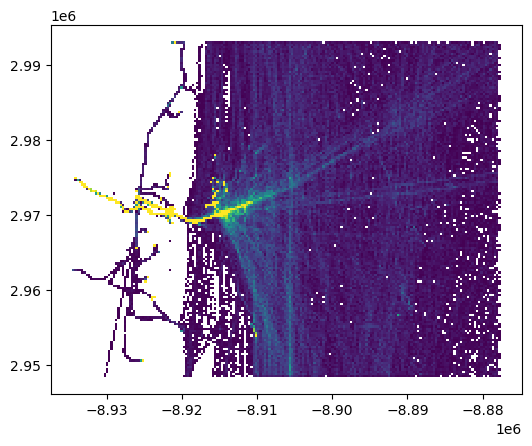

In [44]:
# static plot works
# 
# with following prompt template - show second part only 
# 
"""
sample code:

import geofunctions as S
import pyspark.sql.functions as F
import geopandas as gp

#Perform Spatial Binning
df = (
    df.select(S.st_lontoq("<lon column>", cell), S.st_lattor("<lat column>", <cell size>))
    .groupBy("q", "r")
    .count()
    .select(
        S.st_qtox("q", <cell size>),
        S.st_rtoy("r", <cell size>),
        "count",
    )
    .select(
        S.st_cell("x", "y", <cell size>).alias("geometry"),
        F.least("count", F.lit(<max count>)).alias("count"),
    )
    .orderBy("count")
)

# this part should be used only when users ask for showing the result in a map
df = df.toPandas()
df.geometry = df.geometry.apply(lambda _: bytes(_))
df.geometry = gp.GeoSeries.from_wkb(df.geometry)
gdf = gp.GeoDataFrame(df, crs="EPSG:3857")
gdf.sindex
gdf.plot("count")
"""
import geofunctions as S
import pyspark.sql.functions as F
import geopandas as gp

# Define variables
lon_col = "lon"
lat_col = "lat"
cell_size = 300
max_count = 70

# Perform Spatial Binning
df = (
    df.select(S.st_lontoq(lon_col, cell_size), S.st_lattor(lat_col, cell_size))
    .groupBy("q", "r")
    .count()
    .select(
        S.st_qtox("q", cell_size),
        S.st_rtoy("r", cell_size),
        "count",
    )
    .select(
        S.st_cell("x", "y", cell_size).alias("geometry"),
        F.least("count", F.lit(max_count)).alias("count"),
    )
    .orderBy("count")
)

# Convert to GeoDataFrame and plot
df = df.toPandas()
df.geometry = df.geometry.apply(lambda _: bytes(_))
df.geometry = gp.GeoSeries.from_wkb(df.geometry)
gdf = gp.GeoDataFrame(df, crs="EPSG:3857")
gdf.plot(column="count")